In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import scipy.interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import scipy.ndimage.filters as fi
from scipy.optimize import curve_fit
from sklearn.neighbors import NearestNeighbors
import gudhi
import os
import glob
import colorcet as cc

## Load persistence diagram data
Load all data (consisting of the list of angles of all spins) and extract the corresponding temperature from the filepath.

In [2]:
# Get list of files for given lattice size
L=20
flist=np.sort(glob.glob("Data_XY/L=%i_K=40/*/*.txt" % L))

# Load spin angle data, noting temp and winding numbers
vecs = np.empty([0, L*L])
temps = np.empty([0])

for f in flist:
    data = np.loadtxt(f)
    vecs = np.append(vecs, [data.flatten()], axis=0)
    
    temp = float(f[20:24])
    temps = np.append(temps, [temp])
    
tUnique = np.unique(temps)

Display counts of how many runs have been loaded for each temperature.

In [3]:
# Display how many runs of each temp have been loaded
[sets, counts] = np.unique(temps, axis=0, return_counts=True)
sortInd = np.argsort(sets)
sets = sets[sortInd]
counts = counts[sortInd]

for i in range(len(counts)):
    print("%ix \tT = %.2f" % (counts[i], sets[i]))

200x 	T = 0.05
200x 	T = 0.10
200x 	T = 0.15
200x 	T = 0.20
200x 	T = 0.25
200x 	T = 0.30
200x 	T = 0.35
200x 	T = 0.40
200x 	T = 0.45
200x 	T = 0.50
200x 	T = 0.55
200x 	T = 0.60
200x 	T = 0.65
200x 	T = 0.70
200x 	T = 0.75
200x 	T = 0.80
200x 	T = 0.85
200x 	T = 0.90
200x 	T = 0.95
200x 	T = 1.00
200x 	T = 1.05
200x 	T = 1.10
200x 	T = 1.15
200x 	T = 1.20
200x 	T = 1.25
200x 	T = 1.30
200x 	T = 1.35
200x 	T = 1.40
200x 	T = 1.45
200x 	T = 1.50


## Computing persistence images
Spins are reoriented so that the total magnetization lies at θ=0 and all angles live in [-π,π).

Persistence images are constructed from from a periodic cubical complex. A weight log(1+p) is used to kill low-persistence features/emphasize long-lived features which are more "real". Having the weight vanish for p=0 is part of the stability theorems.

**Cycles which never die are assigned a death 1.5π to artificially raise them above those that have death very close to π**

2-cycles are not used because there is only ever one of these.

In [4]:
def reorient(v):
    # shift spins by a constant so that they lie in [-pi,pi] with net magnetization at zero angle
    
    components = np.array([[np.cos(s), np.sin(s)] for s in v])
    [mx, my] = np.sum(components, axis=0)
    mAngle = np.arctan2(my, mx)
    newV = (v - mAngle + np.pi) % (2 * np.pi) - np.pi
    
    return newV

In [89]:
def PerIm(vIndex, nbins, stdev, res=10):
    # v : array of spin angles
    # nbins : [#,#] number of bins (resolution) along each axis in persistence image
    # sigma : stdev for gaussian smearing
    
    if vIndex % 400 == 0:
        print("%6.2f %%" % (100 * vIndex / len(vecs)))
    
    v = vecs[vIndex]
    
    spins = reorient(v)
    
    pcc = gudhi.PeriodicCubicalComplex(top_dimensional_cells = spins, dimensions=[L,L], periodic_dimensions=[True,True])
    
    PD = pcc.persistence()
    
    PI0 = np.empty([0, 2])
    PI1 = np.empty([0, 2])
    
    for pt in PD:
        hom = pt[0]
        if hom == 0:
            if pt[1][1] != float('inf'):
                PI0 = np.append(PI0, [[pt[1][0], pt[1][1] - pt[1][0]]], axis=0)
#             else:
#                 PI0 = np.append(PI0, [[pt[1][0], 1.5*np.pi - pt[1][0]]], axis=0)
        elif hom == 1:
            if pt[1][1] != float('inf'):
                PI1 = np.append(PI1, [[pt[1][0], pt[1][1] - pt[1][0]]], axis=0)
#             else:
#                 PI1 = np.append(PI1, [[pt[1][0], 1.5*np.pi - pt[1][0]]], axis=0)
    
    x = np.linspace(-np.pi, np.pi, res*nbins[0])
    y = np.linspace(0, 2.5*np.pi, res*nbins[1])
#     y = np.linspace(0, 2*np.pi, res*nbins[1])
        
    xx, yy = np.meshgrid(x, y, sparse=True)
    z0=np.zeros([res*nbins[1], res*nbins[0]])
    z1=np.zeros([res*nbins[1], res*nbins[0]])
    
    for pt in PI0:
        birth = pt[0]
        persistence = pt[1]
        weight = np.log(1 + persistence)
        z0 += weight * np.exp((-0.5*(xx-birth)**2-0.5*(yy-persistence)**2)*stdev**-2)
    
    for pt in PI1:
        birth = pt[0]
        persistence = pt[1]
        weight = np.log(1 + persistence)
        z1 += weight * np.exp((-0.5*(xx-birth)**2-0.5*(yy-persistence)**2)*stdev**-2)
    
    PI0_final = z0.reshape(nbins[1], res, nbins[0], res).sum(3).sum(1)
    PI1_final = z1.reshape(nbins[1], res, nbins[0], res).sum(3).sum(1)
    
#     PI0_final /= np.sum(PI0_final)
#     PI1_final /= np.sum(PI1_final)
    
    return [PI0_final, PI1_final]

In [90]:
# Parameters for creating persistence image
nbins = [17, 21]
sigma = 0.25

# Calculate persistence image for each homology and merge into single array
pi_list = np.array([np.block(PerIm(vIndex, nbins, sigma, 10)) for vIndex in range(len(vecs))])
print("100.00 %\n\nDONE")

  0.00 %
  6.67 %
 13.33 %
 20.00 %
 26.67 %
 33.33 %
 40.00 %
 46.67 %
 53.33 %
 60.00 %
 66.67 %
 73.33 %
 80.00 %
 86.67 %
 93.33 %
100.00 %

DONE


Flatten persistence images into 1D arrays.

In [91]:
imgs_array = np.array([pi.flatten() for pi in pi_list])

# Normalize according to L1 norm, i.e. make 'probability density functions'
# imgs_array = preprocessing.normalize(imgs_array, norm='l1')

## An example

T = 0.10


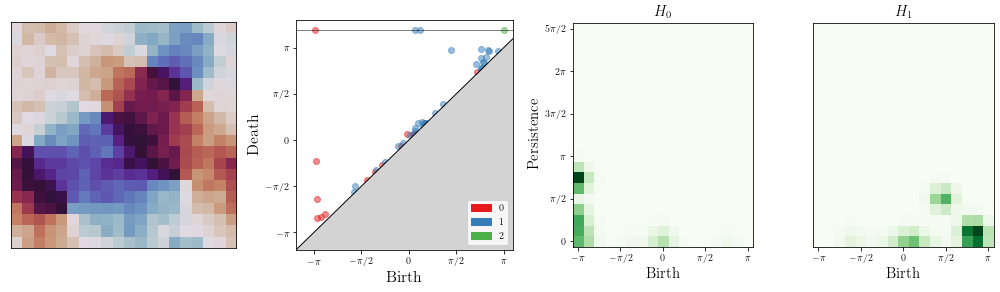

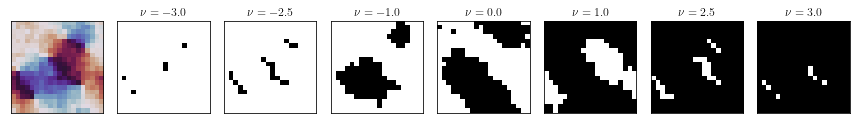

In [92]:
# n = 460
n = 270
v = vecs[n]
print("T = %.2f" % temps[n])

spins = reorient(v)

pcc = gudhi.PeriodicCubicalComplex(top_dimensional_cells = spins, dimensions=[L,L], periodic_dimensions=[True,True])

PI0, PI1 = PerIm(n, [17, 21], 0.25, 10)


# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(111)

# cs = ax.imshow(spins.reshape(L,L), origin='lower', cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
# ax.set_aspect('equal')
# # ax.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.tight_layout()
# plt.show()



fig, axes = plt.subplots(1, 4, figsize=(14,4), gridspec_kw={
                                    'width_ratios': [1.25, 1.2, 1, 1],
                                    'height_ratios': [1]})

axes[0].imshow(spins.reshape(L,L), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
axes[0].set_xticks([])
axes[0].set_yticks([])

gudhi.plot_persistence_diagram(pcc.persistence(), alpha=0.5, legend=True, axes=axes[1])
axes[1].set_title('')
axes[1].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[1].set_xticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
axes[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axes[1].set_yticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])

axes[2].imshow(PI0, origin='lower', cmap='Greens', vmin=0)
axes[2].set_xticks(range(0, 17, 4))
axes[2].set_xticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
axes[2].set_yticks(range(0, 21, 4))
axes[2].set_yticklabels([0, '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$', '$5\pi/2$'])
axes[2].set_xlabel('Birth', fontsize=15)
axes[2].set_ylabel('Persistence', fontsize=15)
axes[2].set_title('$H_0$', fontsize=15)

axes[3].imshow(PI1, origin='lower', cmap='Greens', vmin=0)
axes[3].set_xticks(range(0, 17, 4))
axes[3].set_xticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
axes[3].set_yticks([])
axes[3].set_xlabel('Birth', fontsize=15)
axes[3].set_title('$H_1$', fontsize=15)

plt.tight_layout()
plt.show()


nus = [-3, -2.5, -1, 0, 1, 2.5, 3]

fig, ax = plt.subplots(1, len(nus)+1, figsize=(12,4))

ax[0].imshow(spins.reshape(L,L), cmap='twilight_shifted', vmin=-np.pi, vmax=np.pi)
ax[0].set_xticks([])
ax[0].set_yticks([])

for i in range(len(nus)):
    sublevelspins = (spins < nus[i])
    sublevelspins = sublevelspins.reshape(L,L)
    ax[i+1].imshow(sublevelspins, cmap='Greys')
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title(r'$\nu=%.1f$' % nus[i])

plt.tight_layout()
plt.show()

## Phase classification with logistic regression
Training is done only on data with temperature 'far' from the anticipated critical temperature.

In [93]:
belowTemp = 0.225
aboveTemp = 1.325
far_indices = np.where((temps < belowTemp) | (temps > aboveTemp))[0]
pi_far = imgs_array[far_indices]
temps_far = temps[far_indices]

# 0 for low-temp, 1 for high-temp
labels = [int(t > 0.892) for t in temps_far]

X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(pi_far, labels, temps_far, test_size=0.25)

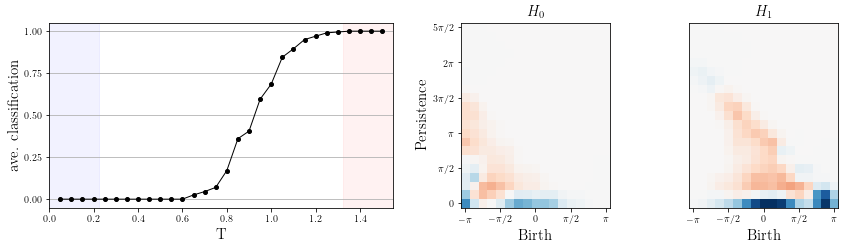

50% cross-over temp: 0.925


In [101]:
logreg = LogisticRegression(C=0.1, solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)

inverse_image = np.copy(logreg.coef_).reshape((nbins[1],2*nbins[0]))


pred = logreg.predict(imgs_array)
avg = np.zeros(len(tUnique))
for i in np.arange(len(tUnique)):
    avg[i] = np.mean(pred[np.where(temps==tUnique[i])[0]])



maxAbsValue = max(abs(logreg.coef_[0]))
norm = colors.DivergingNorm(vmin = -maxAbsValue, vcenter = 0, vmax = maxAbsValue)
# norm = colors.DivergingNorm(vcenter = 0)

fig, axes = plt.subplots(1, 3, figsize=(12,3.5), gridspec_kw={
                           'width_ratios': [2, 1, 1],
                           'height_ratios': [1]})

axes[1].imshow(inverse_image[:,:nbins[0]], origin='lower', cmap='RdBu_r', norm=norm)
axes[1].set_xticks(range(0, nbins[0], 4))
axes[1].set_xticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
axes[1].set_yticks(range(0, nbins[1], 4))
axes[1].set_yticklabels([0, '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$', '$5\pi/2$'])
axes[1].set_xlabel('Birth', fontsize=15)
axes[1].set_ylabel('Persistence', fontsize=15)
axes[1].set_title('$H_0$', fontsize=15)

h1im = axes[2].imshow(inverse_image[:,nbins[0]:], origin='lower', cmap='RdBu_r', norm=norm)
axes[2].set_xticks(range(0, nbins[0], 4))
axes[2].set_xticklabels(['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
axes[2].set_yticks([])
axes[2].set_xlabel('Birth', fontsize=15)
axes[2].set_title('$H_1$', fontsize=15)

    
# Plot regions of training data
axes[0].axvspan(0, belowTemp, color='blue', alpha=0.05)
axes[0].axvspan(aboveTemp, 1.55, color='red', alpha=0.05)

# Plot average classification
axes[0].plot(tUnique, avg, '-o', c='black', lw=1, ms=4)


axes[0].set_xlim([0, 1.55])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_yticks(np.arange(0, 1.01, step=0.25))
axes[0].grid(which='major', axis='y')
axes[0].set_xlabel('T', fontsize=15)
axes[0].set_ylabel('ave. classification', fontsize=15)


plt.tight_layout()
plt.show()

# Identify cross-over temp as critical temp
print('50% cross-over temp:', scipy.interpolate.interp1d(avg, tUnique)(0.5))

## Visualizing persistence images with PCA

In [96]:
pca = PCA(n_components=5)
X_r = pca.fit(imgs_array).transform(imgs_array)

print(pca.explained_variance_ratio_)

[0.41332132 0.08227597 0.05474331 0.03626702 0.03059773]


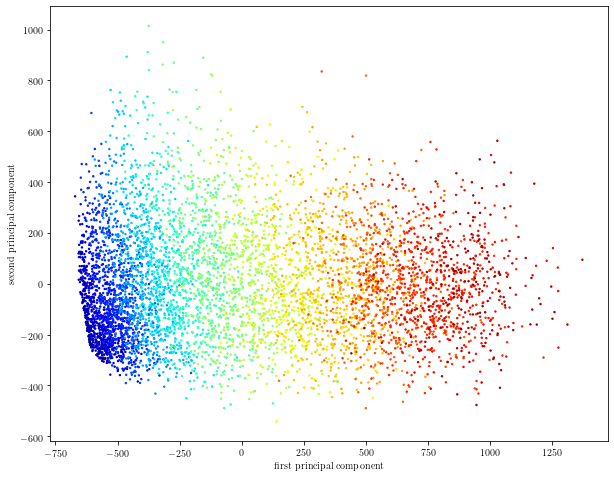

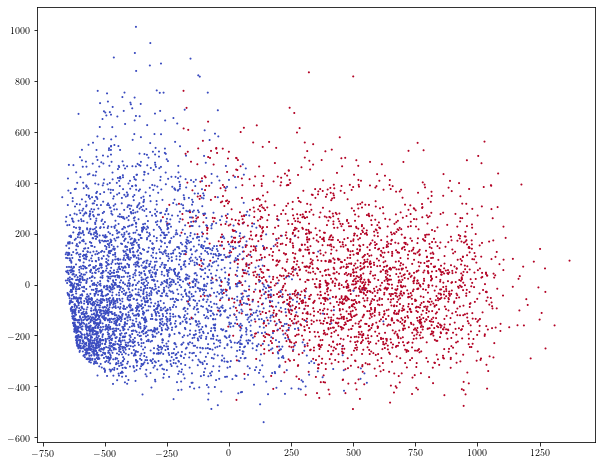

In [97]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,1.6,33)
norm = colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(X_r[:,0], X_r[:,1], c=temps, s=2, cmap=cmap, norm=norm)
# cbar = fig.colorbar(scat)
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,8))
scat = ax.scatter(X_r[:,0], X_r[:,1], c=pred, s=1, cmap='coolwarm')
plt.show()

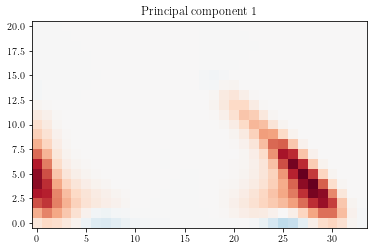

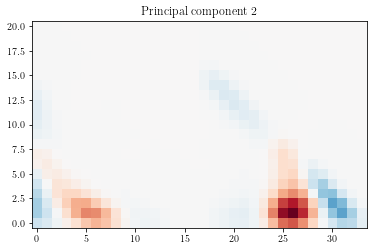

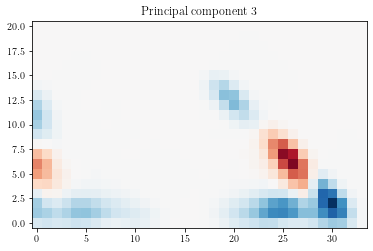

In [98]:
for i in range(3):
    toPlot = (pca.components_)[i]
    maxAbsValue = max(abs(toPlot))
    norm = colors.DivergingNorm(vmin = -maxAbsValue, vcenter = 0, vmax = maxAbsValue)
    
    plt.imshow(toPlot.reshape(nbins[1], 2*nbins[0]), origin='lower', cmap='RdBu_r', norm=norm)
    plt.title('Principal component %i' % (i+1))
    plt.show()

## Death distributions
Compute 1D statistic of death distribution at each temp.

In [99]:
def deathDist(t, numBins):
    binWidth = 2*np.pi / numBins
    binLeftEdges = np.linspace(-np.pi, np.pi, numBins)

    deathH0Freq = np.zeros(numBins)
    deathH1Freq = np.zeros(numBins)

    indices = np.where(temps == t)[0]

    perData = [gudhi.PeriodicCubicalComplex(top_dimensional_cells = reorient(v), dimensions=[L,L], periodic_dimensions=[True,True]) for v in vecs[indices]]
    perData = [pcc.persistence() for pcc in perData]

    for pi in perData:
        for pt in pi:
            if pt[0] == 0:
                if pt[1][1] != np.inf:
                    binIndex = int((pt[1][1] + np.pi) // binWidth)
                    deathH0Freq[binIndex] += 1
            elif pt[0] == 1:
                if pt[1][1] != np.inf:
                    binIndex = int((pt[1][1] + np.pi) // binWidth)
                    deathH1Freq[binIndex] += 1
    
    return [binLeftEdges, deathH0Freq, deathH1Freq]

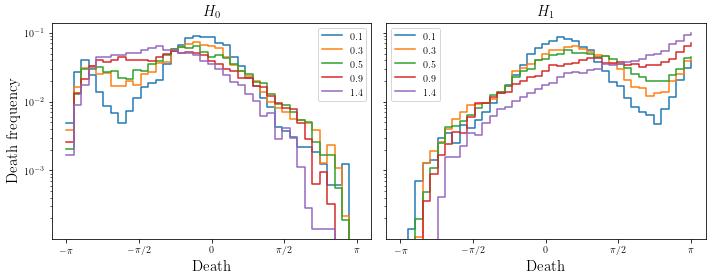

In [100]:
tList = [0.1, 0.3, 0.5, 0.9, 1.4]

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True, sharex=True)

for t in tList:
    ble, dH0, dH1 = deathDist(t, 40)
    dH0 /= sum(dH0)
    dH1 /= sum(dH1)
    ax[0].step(ble, dH0, where='post')
    ax[1].step(ble, dH1, where='post')


plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
ax[0].set_xlabel('Death', fontsize=15)
ax[1].set_xlabel('Death', fontsize=15)

ax[0].set_ylabel('Death frequency', fontsize=15)

plt.yscale('log')

ax[0].set_title('$H_0$', fontsize=15)
ax[1].set_title('$H_1$', fontsize=15)

ax[0].legend(tList)
ax[1].legend(tList)

plt.tight_layout()
plt.show()

Compute distributions for _all_ temps.

In [103]:
numDeathBins = 41
deathH0dists = np.zeros([len(tUnique), numDeathBins])
deathH1dists = np.zeros([len(tUnique), numDeathBins])

for i in range(len(tUnique)):
    t = tUnique[i]
    ble, dH0, dH1 = deathDist(t, numDeathBins)
    dH0 /= sum(dH0)
    dH1 /= sum(dH1)
    
    deathH0dists[i] = dH0
    deathH1dists[i] = dH1

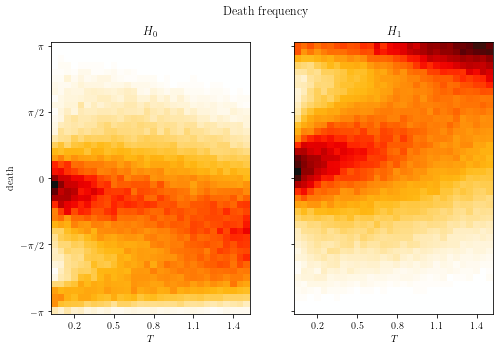

In [113]:
tempTicks = range(3, len(tUnique), 6)

fig, ax = plt.subplots(1, 2, figsize=(8,5), sharey=True, sharex=True)

ax[0].imshow(np.transpose(deathH0dists), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])
ax[1].imshow(np.transpose(deathH1dists), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])

ax[0].set_title('$H_0$')
ax[1].set_title('$H_1$')

ax[0].set_xlabel('$T$')
ax[1].set_xlabel('$T$')

plt.xticks(tempTicks, labels=tUnique[tempTicks])
plt.yticks(range(0, len(deathH0dists[0]), 10), labels=['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])

ax[0].set_ylabel('death')

fig.suptitle("Death frequency")

plt.show()

## Birth distributions
Compute 1D statistic of birth distribution at each temp.

As expected (H0 births) roughly corresponds to -(H1 deaths) and vise versa.

In [419]:
def birthDist(t, numBins):
    binWidth = 2*np.pi / numBins
    binLeftEdges = np.linspace(-np.pi, np.pi, numBins)

    birthH0Freq = np.zeros(numBins)
    birthH1Freq = np.zeros(numBins)

    indices = np.where(temps == t)[0]

    perData = [gudhi.PeriodicCubicalComplex(top_dimensional_cells = reorient(v), dimensions=[L,L], periodic_dimensions=[True,True]) for v in vecs[indices]]
    perData = [pcc.persistence() for pcc in perData]

    for pi in perData:
        for pt in pi:
            if pt[0] == 0:
                binIndex = int((pt[1][0] + np.pi) // binWidth)
                birthH0Freq[binIndex] += 1
            elif pt[0] == 1:
                binIndex = int((pt[1][0] + np.pi) // binWidth)
                birthH1Freq[binIndex] += 1

    return [binLeftEdges, birthH0Freq, birthH1Freq]

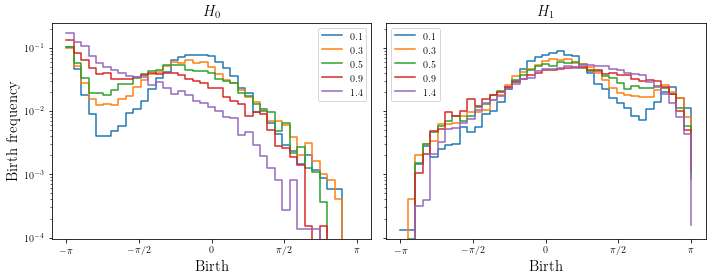

In [420]:
tList = [0.1, 0.3, 0.5, 0.9, 1.4]

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True, sharex=True)

for t in tList:
    ble, bH0, bH1 = birthDist(t, 40)
    bH0 /= sum(bH0)
    bH1 /= sum(bH1)
    ax[0].step(ble, bH0, where='post')
    ax[1].step(ble, bH1, where='post')


plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
ax[0].set_xlabel('Birth', fontsize=15)
ax[1].set_xlabel('Birth', fontsize=15)

ax[0].set_ylabel('Birth frequency', fontsize=15)

plt.yscale('log')

ax[0].set_title('$H_0$', fontsize=15)
ax[1].set_title('$H_1$', fontsize=15)

ax[0].legend(tList)
ax[1].legend(tList)

plt.tight_layout()
plt.show()

Compute distributions for _all_ temps.

In [594]:
numBirthBins = 41
birthH0dists = np.zeros([len(tUnique), numBirthBins])
birthH1dists = np.zeros([len(tUnique), numBirthBins])

for i in range(len(tUnique)):
    t = tUnique[i]
    ble, bH0, bH1 = birthDist(t, numBirthBins)
    bH0 /= sum(bH0)
    bH1 /= sum(bH1)
    
    birthH0dists[i] = bH0
    birthH1dists[i] = bH1

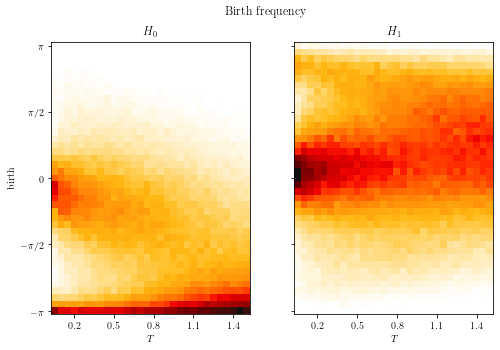

In [595]:
tempTicks = range(3, len(tUnique), 6)

fig, ax = plt.subplots(1, 2, figsize=(8,5), sharey=True, sharex=True)

ax[0].imshow(np.transpose(birthH0dists), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])
ax[1].imshow(np.transpose(birthH1dists), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])

ax[0].set_title('$H_0$')
ax[1].set_title('$H_1$')

ax[0].set_xlabel('$T$')
ax[1].set_xlabel('$T$')

plt.xticks(tempTicks, labels=tUnique[tempTicks])
plt.yticks(range(0, len(birthH0dists[0]), 10), labels=['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])

ax[0].set_ylabel('birth')

fig.suptitle("Birth frequency")

plt.show()

## Betti numbers

In [552]:
numBins = 101

binLeftEdges = np.linspace(-np.pi, np.pi, numBins)
betti0Counts = np.zeros([len(tUnique), numBins])
betti1Counts = np.zeros([len(tUnique), numBins])

for i in range(len(tUnique)):
    indices = np.where(temps == tUnique[i])[0]

    perData = [gudhi.PeriodicCubicalComplex(top_dimensional_cells = reorient(v), dimensions=[L,L], periodic_dimensions=[True,True]) for v in vecs[indices]]
    perData = [pcc.persistence() for pcc in perData]

    for pi in perData:
        for pt in pi:
            if pt[0] == 0:
                if pt[1][1] != np.inf:
                    minIndex = int(((pt[1][0] + np.pi) / (2*np.pi)) * numBins)
                    maxIndex = int(((pt[1][1] + np.pi) / (2*np.pi)) * numBins) + 1
                    betti0Counts[i,minIndex:maxIndex] += 1
            if pt[0] == 1:
                if pt[1][1] != np.inf:
                    minIndex = int(((pt[1][0] + np.pi) / (2*np.pi)) * numBins)
                    maxIndex = int(((pt[1][1] + np.pi) / (2*np.pi)) * numBins) + 1
                    betti1Counts[i,minIndex:maxIndex] += 1

    betti0Counts[i] /= len(indices)
    betti1Counts[i] /= len(indices)


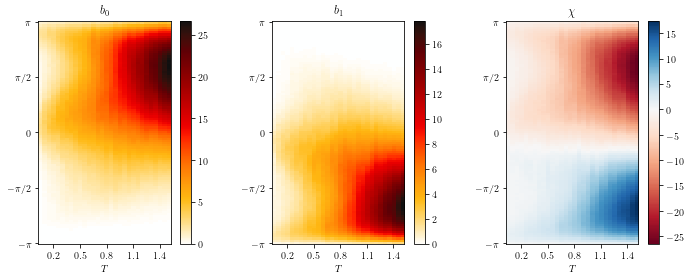

In [598]:
tempTicks = range(3, len(tUnique), 6)

fig, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True)

b0 = ax[0].imshow(np.transpose(betti1Counts), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])
fig.colorbar(b0, ax=ax[0])

b1 = ax[1].imshow(np.transpose(betti0Counts), origin='lower', cmap=cc.cm['linear_kryw_5_100_c67_r'])
fig.colorbar(b1, ax=ax[1])

chi = ax[2].imshow(np.transpose(betti0Counts - betti1Counts), origin='lower', cmap='RdBu', norm=colors.DivergingNorm(vcenter=0))
fig.colorbar(chi, ax=ax[2])

for i in range(3):
    ax[i].set_yticks(range(0, len(betti0Counts[0]), 25))
    ax[i].set_yticklabels(['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
    ax[i].set_xlabel('$T$')

ax[0].set_title('$b_0$')
ax[1].set_title('$b_1$')
ax[2].set_title('$\chi$')

ax[0].set_aspect(0.5)
ax[1].set_aspect(0.5)
ax[2].set_aspect(0.5)

ax[2].set_xticks(tempTicks)
ax[2].set_xticklabels(tUnique[tempTicks])

plt.tight_layout()
plt.show()